In [40]:
'''
Importing packages 
'''
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import tkinter as tk
from tkinter import filedialog

class FxHedgingSimulator():
    
    def __init__(self, fx0, mu, vol, day_count, years, sim,k,r,notional):
        ''' Initial Parameters for this class
    
        Parameters
        ==========
        fx0:float
            initial FX rate
        mu :float
             drift
        vol:float
            constant volatility
        T : float
            final time horizon (fixed at 1)
        day_count:int
                  number of trading days per year (360, 252, 365)
        years:int
              number of years that are simulated
        steps:int
              number of steps per path
        sim:int
            number of simulated paths
        k:float
          strike price (in this case fx rate)
        r:float
          risk-free rate
        notional:float
                 notional size of the FX option contract
        paths:ndarray
              simulated paths of fx rate
        cf:dataframe
           list of cash flows 
        '''
        
        self.fx0 = fx0
        self.mu = mu 
        self.vol = vol
        self.day_count = day_count
        self.years = years
        self.steps = day_count*years
        self.T = 1 
        self.sim = sim
        self.k = k
        self.r = r
        self.notional = notional
        self.paths = self.gbm_simulator()
        self.cf = self.DataReader()
        
    def gbm_simulator(self):
        ''' Generate Monte Carlo paths for geometric Brownian motion.
    
        Parameters
        ==========
        fx0:float
            initial stock/index value
        mu :float
             drift
        vol:float
            constant volatility
        T : float
            final time horizon (fixed at 1)
        day_count:int
                  number of trading days per year (360, 252, 365)
        years:int
              number of years that are simulated
        steps:int
              number of steps per path
        sim:int
            number of simulated paths


        Returns
        =======
        sim_paths : ndarray, shape (steps + 1, sim)
            simulated paths given the parameters
        '''
        dt = float(self.T) / self.steps #calculates the change in time
        sim = np.zeros((self.steps + 1, self.sim), np.float64) #creates ndarray of zeros with shape of (steps+1, sim)
        sim[0] = self.fx0 #initial FX rate is given to the first row of sim_paths array
        
        #iterates through each step of all the paths 
        #each step is cumulated with the GBM model
        for t in range(1, self.steps + 1):
            #standard normal N(0,1)
            norm = np.random.standard_normal(self.sim) 
            norm = (norm - norm.mean()) / norm.std()
            #SDE
            sim[t] = sim[t - 1] * np.exp((self.mu - self.vol ** 2 /2) * dt + self.vol * np.sqrt(dt) * norm)
        return sim
    
    def irr_calculator(self, withFxOption):
        ''' Generates IRR for individual path with and without FX Hedging
    
        Parameters
        ==========
        day_count:int
                  number of trading days per year (360, 252, 365)
        k:float
          strike price (in this case fx rate)
        r:float
          risk-free rate
        notional:float
                 notional size of the FX option contract
        paths:ndarray
              simulated paths of fx rate
        withFxOption: boolean
                      determines if IRR is calculated with or without FX Option Hedging
              
        Returns
        =======
        paths_irr : ndarray, shape (1, sim)
            array of IRR of each path      
        '''
        
        #(1): Pulls the cash flow amounts from the excel
        total_cf = self.cf 
        cfs = total_cf[1:6] #split the initial investment and incoming cash flows
        
        #(2): create new paths that will only contain simulated fx rates corresponding to the date of the cash flows    
        #initially, new_paths array will contain initial investment converted with initial fx rate
        paths = self.paths #grabs the simulated paths 
        new_paths = np.array([(total_cf[0])*paths[0]])#converting investment(in GBP) to USD
        
        
        #(3): Convert the cash flows with simulated fx rates which corresponds to the payment date of cash flow
        for i in range(0,len(cfs)):
            index = (i+1)*self.day_count #adjust the index to match with corresponding date
            new_paths = np.vstack((new_paths, np.array(cfs[i+1]/paths[index]))) #stacks converted cash flows for IRR calculation
        
        #(4): Condition to check if IRR Calculation is done with FX hedging or not
        #If true, then initial investment will be subtracted with the premium of the fx option
        #as well the final cash flow will be summed with the payoff of the fx option
        if withFxOption == True: 
            premium, payoff = self.FxOption_Val()
            new_paths[0] = new_paths[0]-premium
            new_paths[-1] = new_paths[-1] + payoff
        else: 
            pass 
        
        #(5): transpose the new_paths array for convenient IRR calculation,specifically indexing       
        new_paths = new_paths.T
        
        #(6): initially create paths_irr array that will contain IRR of all the paths with converted cash flows
        paths_irr = np.zeros((np.size(new_paths,0),1), np.float64)
        
        #Cont'd (6): iterate through each path to calculate the IRR and insert the value into paths_irr array
        for j in range(0, np.size(new_paths,0)):
            paths_irr[j] = round(np.irr(new_paths[j]),10)
        
        #(7): Transpose paths_irr array for convenience, and array of irr is contain in double square bracket "[]"
        #thus index 0 is used to extract the array of IRR
        paths_irr = paths_irr.T
        paths_irr = paths_irr[0]
        
        return paths_irr
    
    def FxOption_Val(self):
            ''' Valuation of FX Option with GBM simulations

            Parameters
            ==========
            steps:int
                  number of steps per path    
            k:float
              strike price (in this case fx rate)
            r:float
              risk-free rate
            notional:float
                     notional size of the FX option contract
            paths:ndarray
                  simulated paths of fx rate

            Returns
            =======
            premium : float
                premium/fair market value of the FX option based on GBM simulations 

            payoff : ndarray, shape(1,sim)
                array of payoff from FX option at the end of the maturity
            '''
            
            paths = self.paths #simulated paths of fx rates
            fxT = paths[-1] #extract the fx rates at the maturity
            
            # calculates the payoff of the put option
            payoff = self.notional*np.maximum(self.k - fxT, 0)  
            premium = np.exp(-self.r * self.steps) * np.mean(payoff)  # Discount the expected value of payoff to inception
            return premium, payoff      
    
    def plot(self, withFXOption):
        ''' plots the distribution of array of IRR with percentile of 95%,50%,5%
    
        Parameters
        ==========
        withFxOption: boolean
                      determines if IRR is calculated with or without FX Option Hedging

        '''
        
        paths_irr = self.irr_calculator(withFXOption) #grab array of IRR from IRR Calculator function
        ### Calculates 95%,50%,5% percentile of the IRR 
        percent95 = np.percentile(paths_irr,95) 
        percent50 = np.percentile(paths_irr,50)
        percent5 = np.percentile(paths_irr,5)
        
        #Plotting the distribution of IRRs
        plt.hist(paths_irr, bins=70) 
        ### Use colored vertical lines to identify the percentiles 
        plt.axvline(x=percent95,color='k', linestyle='--',label='95%') 
        plt.axvline(x=percent50,color='r', linestyle='--',label='50%')
        plt.axvline(x=percent5,color='g', linestyle='--',label='5%')
        plt.xlabel("IRR")
        plt.ylabel("Count")
        if withFXOption:
            plt.title('Distribution of IRR with FX Hedging')
        else: 
            plt.title('Distribution of IRR without FX Hedging')
        plt.legend()
        plt.grid(True)
    
    
    def editor(self, fx0, mu, vol, day_count, years, sim, k, r, notional):
        '''Allows the user to edit the parameters, whenever parameters used for the simulations are changed then 
           it automatically re-simulates the paths with new parameters. 
           
           Parameters used for valuation of FX option can also change 
        
        Parameters
        ==========
        fx0:float
            initial stock/index value
        mu :float
             drift
        vol:float
            constant volatility
        T : float
            final time horizon (fixed at 1)
        day_count:int
                  number of trading days per year (360, 252, 365)
        years:int
              number of years that are simulated
        steps:int
              number of steps per path
        sim:int
            number of simulated paths
        k:float
          strike price (in this case fx rate)
        r:float
          risk-free rate
        notional:float
                 notional size of the FX option contract
        paths:ndarray
              simulated paths of fx rate
        '''
        
        #Conditions to ensure if any parameters used in the simulation is changed
        if self.fx0 != fx0 or self.mu != mu or self.vol != vol or self.day_count != day_count or self.years != years or self.sim != sim:
            self.fx0 = fx0
            self.mu = mu 
            self.vol = vol
            self.day_count = day_count
            self.years = years
            self.steps = day_count*years
            self.T = 1 
            self.sim = sim
            self.paths = self.gbm_simulator()
        else:
            pass
        
        #Parameters for FX Option
        self.k = k
        self.r = r
        self.notional = notional
        
    def DataReader(self):
        '''
        Open file dialog to ask the user to select the file.
        Extracts required table from the selected excel file
        '''
        
        root = tk.Tk() 
        root.withdraw() 
        file_path = filedialog.askopenfilename(title="Select the file") #Opens File Dialog
        
        df = pd.read_excel(file_path)
        cash_flow = df['Cashflow Amount (in Local Asset Currecny)']
        return cash_flow
    

<ipython-input-41-15601f464960>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  m.show()
<ipython-input-40-5e524fd47cc0>:158: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).
  paths_irr[j] = round(np.irr(new_paths[j]),10)
<ipython-input-41-15601f464960>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-41-15601f464960>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


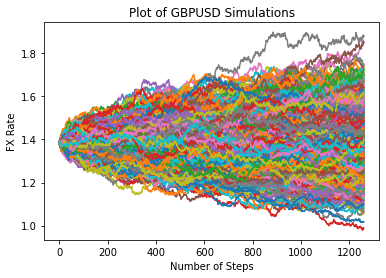

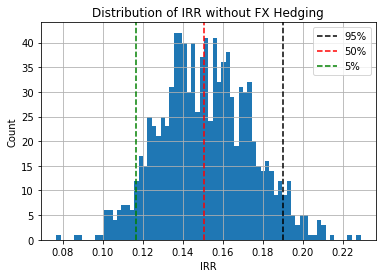

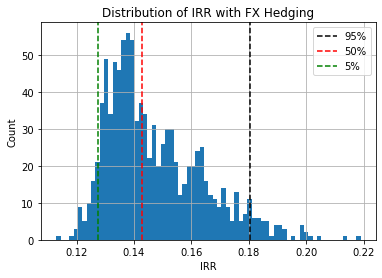

In [41]:
#Parameters: 
fx0 = 1.385
mu = 0
vol = 0.1
day_count = 252
years = 5
sim = 1000
k = 1.3925
r = 0 
notional = 100_000_000

#Running Simulations
simulation1 = FxHedgingSimulator(fx0, mu, vol, day_count, years, sim,k,r,notional)

#Plotting the simulation of FX rate
m = plt.figure(1)
plt.plot(simulation1.paths)
plt.xlabel("Number of Steps")
plt.ylabel("FX Rate")
plt.title("Plot of GBPUSD Simulations")
m.show()

#Distribution of IRR without FX hedging
f = plt.figure(2)
simulation1.plot(False)
f.show()

#Distribution of IRR with FX hedging
g = plt.figure(3)
simulation1.plot(True)
g.show()



Based on the comparison of the two plots, it is evident the put option provides the floor effect such that it limits the drop of IRR. However, due to premium of the option, investment without FX hedging does have higher likelihood achieving stronger IRR (i.e >18%) than investment with FX Hedging. However, it also means investment without FX hedging has the probability to earn weak IRR (<10%), whereas the put option floors the IRR from dropping below 10%. 

# In-Depth Detail of Code
    
## Monte Carlo Simulation with Geometric Brownian Motion
For this simulation, following SDE:

$$F_t = F_{t-1} exp((\mu - \frac{\sigma^2}{2}t + \sigma W_t)$$

where 
$F_t$ is the FX rate at time $t$

$F_{t-1}$ is the FX rate at time $t-1$

$\mu$ is the drift

$\sigma$ is the volatility of FX rate

$W_t$ is the Wiener Process

In [11]:
def gbm_simulator(self):
        ''' Generate Monte Carlo paths for geometric Brownian motion.
    
        Parameters
        ==========
        fx0:float
            initial stock/index value
        mu :float
             drift
        vol:float
            constant volatility
        T : float
            final time horizon (fixed at 1)
        day_count:int
                  number of trading days per year (360, 252, 365)
        years:int
              number of years that are simulated
        steps:int
              number of steps per path
        sim:int
            number of simulated paths


        Returns
        =======
        sim_paths : ndarray, shape (steps + 1, sim)
            simulated paths given the parameters
        '''
        dt = float(self.T) / self.steps #calculates the change in time
        sim_paths = np.zeros((self.steps + 1, self.sim), np.float64) #creates ndarray of zeros with shape of (steps+1, sim)
        sim_paths[0] = self.fx0 #initial FX rate is given to the first row of sim_paths array
        
        #iterates through each step of all the paths 
        #each step is cumulated with the GBM model
        for t in range(1, self.steps + 1):
            rand = np.random.standard_normal(self.sim)
            rand = (rand - rand.mean()) / rand.std()
            sim_paths[t] = sim_paths[t - 1] * np.exp((self.mu - self.vol ** 2 /2) * dt + self.vol * np.sqrt(dt) * rand)
        return sim_paths

## Valuation of FX Option

When valuing European Put Option on a FX rate with simulated paths from Geometric Brownian Motion, since it is European option, calculate the payoff of the option at the maturity and discount the expected value of the payoffs to the inception.  

$$V_0 = exp(-r*T)*\mathbf{E}(payoffs)$$ 

In [ ]:
 def FxOption_Val(self):
            ''' Valuation of FX Option with GBM simulations

            Parameters
            ==========
            steps:int
                  number of steps per path    
            k:float
              strike price (in this case fx rate)
            r:float
              risk-free rate
            notional:float
                     notional size of the FX option contract
            paths:ndarray
                  simulated paths of fx rate

            Returns
            =======
            premium : float
                premium/fair market value of the FX option based on GBM simulations 

            payoff : ndarray, shape(1,sim)
                array of payoff from FX option at the end of the maturity
            '''
            
            paths = self.paths #simulated paths of fx rates
            fxT = paths[-1] #extract the fx rates at the maturity
            payoff = np.maximum(self.k - fxT, 0)  # calculates the payoff of the put option for each path
            P0 = np.exp(-self.r * self.steps) * np.mean(payoff)  # Discount the expected value of payoff to inception
            premium = P0*self.notional #calculate the total cost of the FX Put Option

            return premium, payoff      